# Data mining project
## Data presentation and loading
BOUJEMT Amine p1707726  
REJAUMONT Quentin p1609656

## Description des données
Nos données sont constitués de plusieurs jeu de données différent, a savoir:
- Position des communes en france (39000)
- Une prédiction des loyers par commune en France (35000)
- La population par commune en France (35000)
- Les salaires par communes en France divisés en plusieurs catégories (5000, données issue des DADS/DSN soumise au secret statistique, nous avons donc ici seulement les villes de plus de 2000 habitants).

Nos données ne contiennent pas également les métropoles francaise, ou leur arrondissement.

Nous allons exploiter ces donneés, et essayer de detecter des similarité de comportement/communauté a travers ce dataset en utilisant les différentes méthode vue en vours.
A noter que notre étude se fera sur les 5000 villes ayant une population supérieur a 2000 a cause de la contrainte de notre dataset sur les salaires.
On effectue deux analyse sur notre jeu de données:
- Identification des villes similaires en terme de salaire, population, prix du loyer.

### Downloading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
loyer = pd.read_csv('./data/loyer-appart.csv',encoding="cp1252", delimiter=";",skipinitialspace=True, usecols=['INSEE','LIBGEO','loypredm2','DEP','REG'])
position = pd.read_csv('./data/position.csv', delimiter=';', usecols=['Code_commune_INSEE', 'coordonnees_gps'])
population = pd.read_csv('./data/densite.csv', encoding="cp1252", delimiter=";", usecols=['code_com', 'population', 'deg_densite'])
salaires = pd.read_csv('./data/salaire.csv', delimiter=';', encoding="cp1252", usecols=['CODGEO', 'SNHM18', 'SNHMHC18', 'SNHMHE18', 'SNHMHO18', 'SNHMF18', 'SNHMFC18', 'SNHMFE18', 'SNHMFO18'])

## Formatage des données
Avant toute chose nous allons rassembler nos données en un seul dataset, et typer nos données dans le bon format afin de facilité les futurs traitements 

In [3]:
dataset = pd.merge(loyer, position, left_on='INSEE', right_on='Code_commune_INSEE')
dataset = pd.merge(dataset, population, left_on='INSEE', right_on='code_com')
dataset = pd.merge(dataset, salaires, left_on='INSEE', right_on='CODGEO')

In [4]:
dataset['latittude'] = dataset['coordonnees_gps'].apply(lambda x: x.split(',')[0])
dataset['longitude'] = dataset['coordonnees_gps'].apply(lambda x: x.split(',')[1])
dataset.drop(['coordonnees_gps', 'Code_commune_INSEE', 'CODGEO'], axis=1, inplace=True)
dataset.drop_duplicates(subset='INSEE', inplace=True)

In [5]:
columns = dataset.columns
num_cols = []
usefull_col = salaires.columns[1:].values
usefull_col = np.append(usefull_col, ['loypredm2', 'population', 'deg_densite'])
for col in columns:
  if not col == 'LIBGEO':
    num_cols.append(col)
    if not col == 'population' and not col == 'REG' and not col == 'deg_densite':
      dataset[col] = dataset[col].apply(lambda x: x.replace(',', '.'))
      dataset[col] = pd.to_numeric(dataset[col], errors='coerce')  

In [6]:
usefull_col_1 = ['loypredm2', 'population', 'deg_densite', 'SNHM18']

## Analyse des données
On s'interessera ici, au prix du loyer, la densité, la population, ainsi que le degré de densité des villes. Ce sont les données que nous utiliserons pour une première analyse.
### Moyenne
On commence par regarder les informations basique, la moyenne, les quartiles, le min, le max de notre dataset pour chaque variable
On observe alors une population moyenne d'environ 9000, un salaire net horaire moyen de 14.4€.  
Sachant que la moyenne est de 9000 et que l'on a un maximum atteint pour 468 milles habitants, on a probablement pas mal de ville entre 2000 et 8000 habitant.

In [9]:
dataset[usefull_col_1].describe()

loypredm2     population  deg_densite       SNHM18
count  5027.000000    5027.000000  5027.000000  5027.000000
mean     10.712482    9043.827332     2.282276    14.460911
std       2.750642   18518.545020     0.708716     2.858894
min       5.375503    1952.000000     1.000000    10.400000
25%       8.833189    2759.000000     2.000000    12.700000
50%      10.110782    4167.000000     2.000000    13.700000
75%      11.951879    7797.500000     3.000000    15.300000
max      29.982547  486828.000000     4.000000    44.600000

### Corrélation entre nos variables
On peut observer avec le tableau ci-dessous ou les graphiques, qu'il n'y pas de corrélation entre la population d'une ville, et le salaire moyen de celle-ci  
On peut également observer des corrélations assez importantes entre:
- loyer - salaire
- densite - loyer
- salaire - loyer

In [10]:
dataset[usefull_col_1].corr()

loypredm2  population  deg_densite    SNHM18
loypredm2     1.000000    0.273722    -0.555039  0.638921
population    0.273722    1.000000    -0.399783  0.064766
deg_densite  -0.555039   -0.399783     1.000000 -0.334734
SNHM18        0.638921    0.064766    -0.334734  1.000000

On peut bien constater ci-dessous une corrélation linéaire entre le loyer et le salaire.  

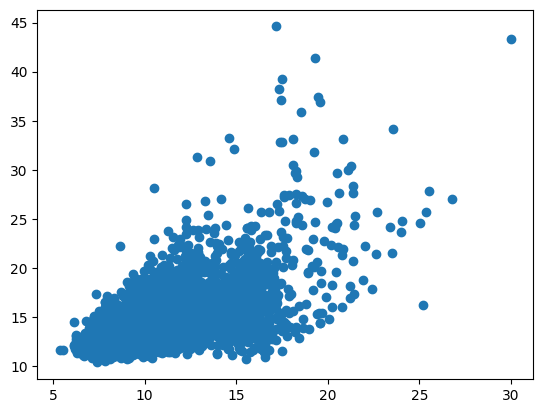

In [12]:
plt.scatter(dataset['loypredm2'], dataset['SNHM18'])

A l'inverse on constate ci-dessous qu'il n'y a pas de corrélation entre nos variables salaire, et population.

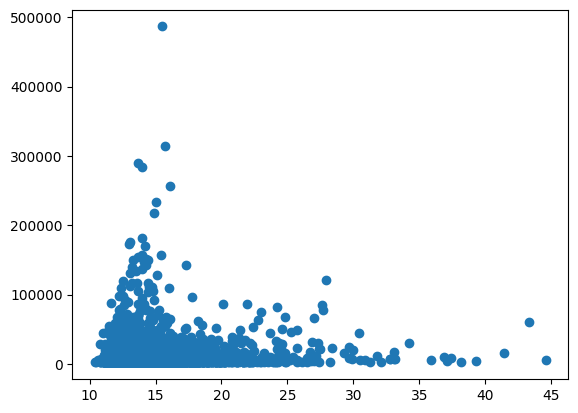

In [454]:
plt.scatter(dataset['SNHM18'], dataset['population'])

### Distribution de nos variables
On observe ici la distribution de nos variables, afin d'éviter/identifier de potentiel biais dans nos futur analyse.
On remarque donc en affichant la distribution de nos variables:
- loypredm2: plutot bien réparties, s'apparente a une loie normale.
- population: la grande majorité des communes ont moins de 5000 habitants, ce qui confirme, et précise notre déduction faite précedemment lors de la description de nos variables.
- Degré de densité: les villes très dense sont très peu nombreuse (proche de 0)
- Salaire: la très grande majorité des villes ont un taux horaire compris entre 10 et 20

array([[<AxesSubplot: title={'center': 'loypredm2'}>,
        <AxesSubplot: title={'center': 'population'}>],
       [<AxesSubplot: title={'center': 'deg_densite'}>,
        <AxesSubplot: title={'center': 'SNHM18'}>]], dtype=object)

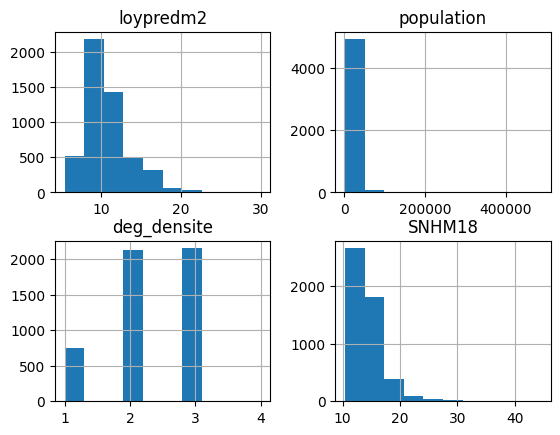

In [8]:
dataset[usefull_col_1].hist()

Nous voulons désormais trouver des comportements similaire entre les différentes villes en France.   
Pour cela nous allons utiliser une méthode clustering. Il nous faut avant cela définir quelle méthode utiliser.  
Pour cela nous allons projeter nos données dans un espace en deux dimensions, afin de pouvoir les visualiser, nous choisirons ensuite une méthode de cluster adapté en fonction de cette visualisation.  
Avant de commencer cette dernière nous allons également devoir normaliser nos données.
## Normalisation des données

In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from random import randint
from sklearn.metrics import silhouette_samples, silhouette_score
from utils import utils
from sklearn.manifold import TSNE

In [13]:
ss = StandardScaler()
ss.fit(dataset[usefull_col_1])
data = ss.transform(dataset[usefull_col_1])

## Visualisation des données
Nous allons utiliser 2 méthode de projection dans 2 dimension, afin de pouvoir comparer les deux
### PCA
Cette méthode utilise une combinaison linéaire de nos autre axes, elle a donc l'avantage de nous permettre d'interpréter nos axes selon nos données.  
On remarque ci-dessous une perte d'information de 20% ce qui est tout a fait acceptable pour avoir une idée de la représentation de nos données dans un espace a grande dimensions.


In [14]:
pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)
pca.explained_variance_ratio_

array([0.54600447, 0.25194813])

In [15]:
print(usefull_col_1)
pca.components_

['loypredm2', 'population', 'deg_densite', 'SNHM18']


array([[ 0.595245  ,  0.34489314, -0.53433881,  0.49113557],
       [-0.2165507 ,  0.76610265, -0.25230615, -0.55003102]])

##### Interprétation des axes
Les villes situés a droite ont un loyer chère, sans etre forcément dense, elle présente aussi un salaire assez elevé.  
Les villes en haut ont tendance a etre très peuplé, mais sans forcément un salaire plus elevée.  
Inversement pour les villes en bas, et les ville a droite.

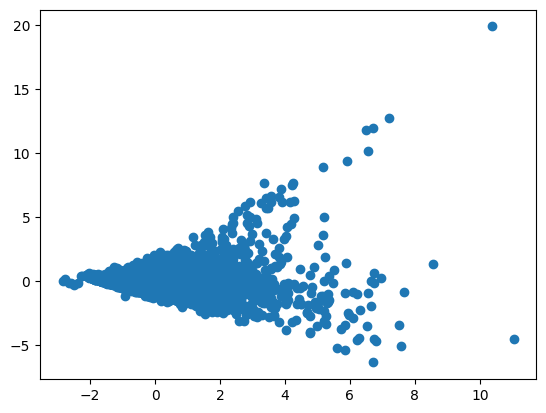

In [16]:
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.show()

C'est difficile avec cette représentation graphique d'en déduire une méthode de clustering a appliqué.  
On va donc se diriger vers une autre méthode de réduction de dimensions.  
Nous allons utiliser une méthode non linéaire contrairement a la méthode du PCA.  
De plus nous essayons d'extraire des cluters contenant des villes proches entre eux. La méthode la plus pertinente semble donc etre Tsne

### TSNE

In [17]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
tsne_data = tsne.fit_transform(data)

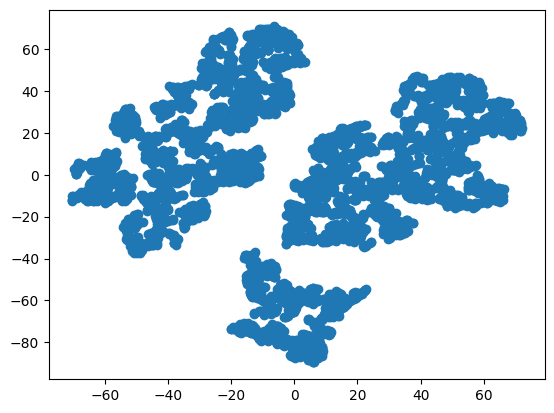

In [18]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()

Nous avons donc une représentation beaucoup plus utile (dans notre cas) qu'avec la méthode pca.
On peut clairement distinguer au moins 3 comportement différent entre nos villes.

### Clustering

#### Choix de la méthode 
Au vue du graphique ci-dessus, on peut supposer que les cluster former ne seront pas forcément de la meme taille, l'utilisation de K-means ne nous semble donc pas ici pertinente, car ce dernier créer des cluters de tailles plus ou moins égale ce qui ne semble pas etre notre cas ici. On va donc se tourner vers les deux autres méthode vue en cours (gaussian mixture et dbscan)  

Dans la représentation TSNE les point "inter-cluster" semble bien distinct les un des autres. On utilisera donc Dbscan qui devrait bien fonctionner ici. 

#### Clustering - DbScan
Afin d'optimiser les paramètres de dbscan, nous allons utiliser silouhette score, qui nous permet de determiner un score de qualité pour nos cluster, dbscan prend 2 paramètres 
- Epsilon
- Nombre d'entité minimum au sein d'entité au sein d'un cluster

Pour trouver le meilleur clustering possible, il nous faut donc determiner ces deux paramètre.
 
 Epsilon corespond a la distance minimal qui doit separer deux point afin de les considérer dans un cluster différent. Pour avoir une idée des valeurs a lui attribuer nous allons tout d'abord tracer un graphique qui représente pour chaque point, la distance entre ce point et le point dont il est plus proche.

In [19]:
import warnings
warnings.filterwarnings('ignore')

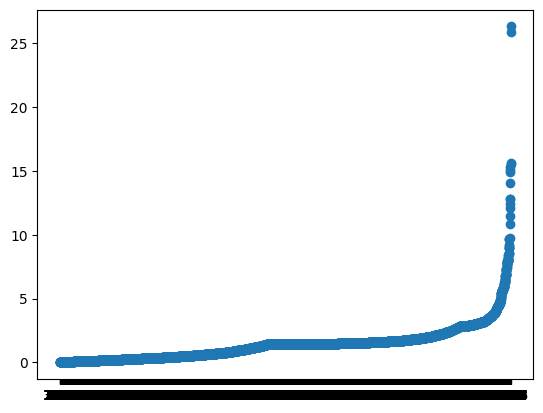

In [20]:
df = pd.DataFrame(data, columns=usefull_col_1).sort_values(by=[usefull_col_1[0], usefull_col_1[1], usefull_col_1[2], usefull_col_1[3]])
df2 = pd.DataFrame(columns=['index', 'distance'])
for i in range(0, len(df) - 1):
  dist = np.linalg.norm(df.iloc[i] - df.iloc[i + 1])
  df2 = df2.append({'index': str(i), 'distance': dist}, ignore_index=True)
df2 = df2.sort_values(by=['distance'])
plt.grid = True
plt.scatter(df2['index'], df2['distance'])


On obtiens alors le graphique ci-dessus, une valeur optimal d'epsilon devrait se trouver a 'l'elbow' de la courbe.  
Environ aux alentours de 5.
Nous allons donc évaluer notre cluster a l'aide du silouhette score avec comme paramètre
- 2.5 < epsilon < 7
- min_cluster = 5 (valeur par défaut, nous étudierons la variation du nombre minimum d'éléments au sein d'un cluster plus tard.)

In [21]:
silouhette_scores = []
indexes = []
for epsilon in range(25, 70):
    dbscan = DBSCAN(eps=epsilon/10)
    dbscan.fit(data)
    silouhette_scores.append(silhouette_score(data, dbscan.labels_, metric='euclidean'))
    indexes.append(epsilon/10)

In [24]:
indexes[np.argmax(silouhette_scores)]

4.3

Nous cherchons la distance minimal qui décrit le mieux nos cluster, nous choisirons donc epsilon = 4.3 comme valeur optimal de epsilon

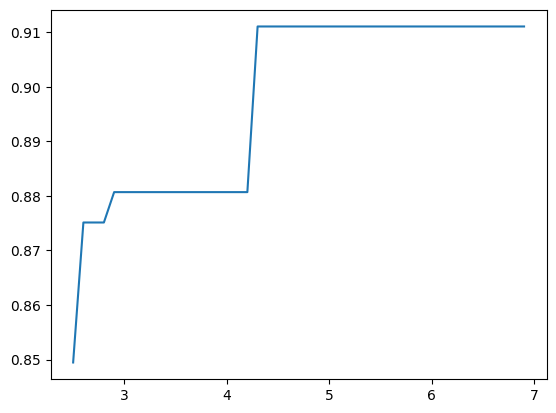

In [25]:
plt.plot(indexes, silouhette_scores)

In [42]:
s_scores = []
for min_cluster_size in range(1, 25):
  dbscan = DBSCAN(eps=4.3, min_samples=min_cluster_size)
  dbscan.fit(data)
  s_scores.append(silhouette_score(data, dbscan.labels_, metric='euclidean'))

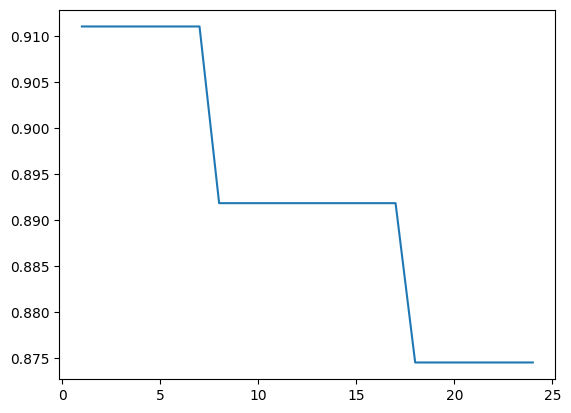

In [43]:
plt.plot([i for i in range(1, 25)], s_scores)

On constate sur le graphique ci dessus, qu'il faudrait un nombre minimum au sein de notre cluster entre 2 et 9 afin d'avoir un silhouette score optimal.

0.9110431849177827


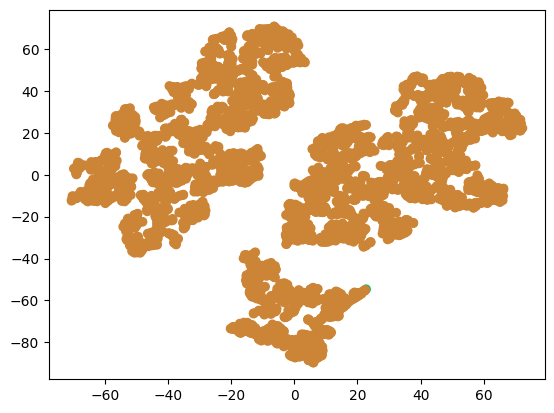

In [27]:
dbscan = DBSCAN(eps=4.3, min_samples=3)
dbscan.fit(data)
ss = silhouette_score(data, dbscan.labels_, metric='euclidean')
print(ss)
colors = utils.generate_colors(25)

dataset['dbscan'] = dbscan.labels_
np.unique(dbscan.labels_)

temp = dataset['dbscan'].apply(lambda x: colors[x + 1]).tolist()

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=temp)
plt.show()

On remarque que si l'on fait cela, certe le silhouette score est maximiser, cependant tout nos points sont réunis en un seul cluster ce qui n'est pas ce qui est voulu ici.
Nous allons donc progressivement diminuer epsilon jusqu'a arriver a une répartition qui nous semble correcte.  
En diminuant progressivement epsilon on arrive a un résultat qui semble correcte pour une valeur de 1.4

In [44]:
dbscan = DBSCAN(eps=1.4, min_samples=3)
dbscan.fit(data)
ss = silhouette_score(data, dbscan.labels_, metric='euclidean')
print(ss)
colors = utils.generate_colors(25) #generate array of random colors of size 25
colors[0] = "red"

dataset['dbscan'] = dbscan.labels_
np.unique(dbscan.labels_)

0.29418496677619466


array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

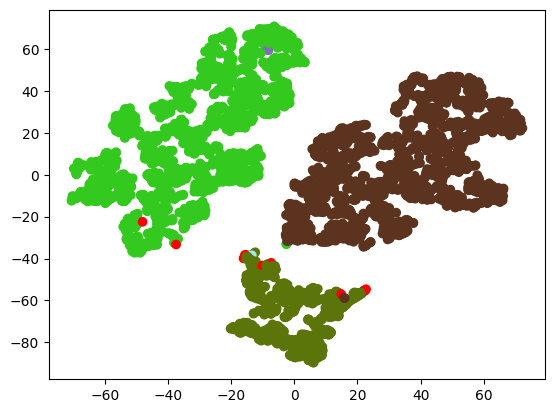

In [45]:
temp = dataset['dbscan'].apply(lambda x: colors[x + 1]).tolist()

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=temp)
plt.show()

On constate que dbscan a créer 5 cluster
On peut également constater que certains point ne sont pas attribué a des clusters (les points rouges)
Nous allons donc allez analyser quelles sont ces communes avec un comportement unique

#### Analyse du clustering
##### Anomaly
Commencons par analyser les communes contenant des anomalies

In [46]:
anomaly = dataset.loc[dataset['dbscan'] == -1]
anomaly[np.append(usefull_col_1, 'LIBGEO')]

loypredm2  population  deg_densite  SNHM18                  LIBGEO
1593  12.232597      486828            1    15.5                Toulouse
1841  13.743347      290053            1    13.7             Montpellier
2625  12.301945      314138            1    15.7                  Nantes
4754  12.860773      284677            1    14.0              Strasbourg
5728  17.479024        4459            2    39.3        L'Étang-la-Ville
5729  17.344726        2951            2    38.2            Feucherolles
5791  17.186849        4915            2    44.6   Saint-Nom-la-Bretèche
5807  21.392218       85205            1    27.6              Versailles
5808  19.320603       15865            1    41.4              Le Vésinet
6115  25.164201        4103            3    16.2            Saint-Tropez
6653  25.503781      121334            1    27.9    Boulogne-Billancourt
6674  29.982547       59940            1    43.3       Neuilly-sur-Seine
6678  20.585490       77986            1    27.7         Rueil-Malmaison
6763  25.361511       22248            1    25.7             Saint-Mandé
6943  12.324885        2772            4    15.2  Montsinéry-Tonnegrande
6991  15.379312      103492            2    14.4              Saint-Paul

On retrouve dans nos comportement marginaux, surtout des grande villes qui s'apparente a des métropoles (Toulouse, montpelier, Nante, Strasbourg)
On retrouve également saint tropez qui a un loyer très chere, et contient pourtant que 4000 habitant.  
On retrouve également des villes qui ne sont pas très peuplé, mais pour qui le prix du loyer est très elevée (Versaille, Neuilly-sur-Seine), ou un salaire important(neully sur seine, Saint nom la breteche).
##### Autre cluster particuliers

In [47]:
display(dataset.loc[dataset['dbscan'] == 3][np.append(usefull_col_1, 'LIBGEO')])
display(dataset.loc[dataset['dbscan'] == 4][np.append(usefull_col_1, 'LIBGEO')])
display(dataset.loc[dataset['dbscan'] == 5][np.append(usefull_col_1, 'LIBGEO')])

loypredm2  population  deg_densite  SNHM18                 LIBGEO
889    6.838508        2315            4    12.1    Mareuil en Périgord
2848   8.613710        2287            4    11.5        Peyre en Aubrac
3015   6.695683        5589            4    11.2        Noyant-Villages
4192   6.239152        2180            4    11.8  Juvigny Val d'Andaine
4209   7.162464        2029            4    12.7         Perche en Nocé
4215   6.897295        2160            4    12.4        Putanges-le-Lac

loypredm2  population  deg_densite  SNHM18    LIBGEO
1647  13.834281      257068            1    16.1  Bordeaux
1994  11.798332      217728            1    14.9    Rennes
3951  13.857356      233098            1    15.0     Lille

loypredm2  population  deg_densite  SNHM18          LIBGEO
5771  14.879151        3027            2    32.1  Morainvilliers
5774  17.368163        7577            2    32.8    Noisy-le-Roi
5776  17.479609        6479            2    32.8         Orgeval

On a 3 cluster remarquable:
- loyer et population faible avec une grande densité.
- Des grandes villes (Bordeaux, Rennes, Lille)
- 3 ville inconnu de tous, qui après une recherche sur google se situe en periphérie de paris avec un salaire moyen > 30.

### Analyse des cluster principaux

In [533]:
dataset[np.append(usefull_col_1, 'dbscan')].groupby(by="dbscan").agg(['describe'])

loypredm2                                                        \
        describe                                                         
           count       mean       std        min        25%        50%   
dbscan                                                                   
-1          16.0  18.635238  5.595139  12.232597  13.522704  17.411875   
 0        2150.0   9.356539  1.877258   5.375503   7.997335   9.028774   
 1        2116.0  10.893011  2.073412   6.140840   9.427341  10.502224   
 2         733.0  13.991335  3.258854   7.403562  11.365269  13.198497   
 3           6.0   7.074469  0.813057   6.239152   6.731389   6.867902   
 4           3.0  13.163323  1.182173  11.798332  12.816306  13.834281   
 5           3.0  16.575641  1.470259  14.879151  16.123657  17.368163   

                             population                                \
                               describe                                 
              75%        max      count           mean            std   
dbscan                                                                  
-1      22.335214  29.982547       16.0  117560.375000  146724.194213   
 0      10.208812  18.273051     2150.0    3494.390233    1789.580665   
 1      12.102832  18.796302     2116.0    7892.531664    8313.028103   
 2      16.227971  26.783829      733.0   25412.388813   29528.559913   
 3       7.096172   8.613710        6.0    2760.000000    1389.658663   
 4      13.845818  13.857356        3.0  235964.666667   19826.049363   
 5      17.423886  17.479609        3.0    5694.333333    2374.321236   

                                                           deg_densite  \
                                                              describe   
             min        25%       50%        75%       max       count   
dbscan                                                                   
-1        2772.0    4801.00   68963.0  162169.75  486828.0        16.0   
 0        1952.0    2385.25    2997.0    4043.00   25330.0      2150.0   
 1        1960.0    3212.00    5446.5    8852.50   84961.0      2116.0   
 2        2046.0    7878.00   14775.0   29806.00  182211.0       733.0   
 3        2029.0    2165.00    2233.5    2308.00    5589.0         6.0   
 4      217728.0  225413.00  233098.0  245083.00  257068.0         3.0   
 5        3027.0    4753.00    6479.0    7028.00    7577.0         3.0   

                                                    SNHM18             \
                                                  describe              
          mean       std  min  25%  50%  75%  max    count       mean   
dbscan                                                                  
-1      1.5625  0.892095  1.0  1.0  1.0  2.0  4.0     16.0  26.275000   
 0      3.0000  0.000000  3.0  3.0  3.0  3.0  3.0   2150.0  13.552884   
 1      2.0000  0.000000  2.0  2.0  2.0  2.0  2.0   2116.0  14.651040   
 2      1.0000  0.000000  1.0  1.0  1.0  1.0  1.0    733.0  16.260437   
 3      4.0000  0.000000  4.0  4.0  4.0  4.0  4.0      6.0  11.950000   
 4      1.0000  0.000000  1.0  1.0  1.0  1.0  1.0      3.0  15.333333   
 5      2.0000  0.000000  2.0  2.0  2.0  2.0  2.0      3.0  32.566667   

                                                      
                                                      
              std   min     25%    50%     75%   max  
dbscan                                                
-1      11.761377  13.7  15.425  26.65  38.475  44.6  
 0       1.658471  10.4  12.400  13.20  14.300  25.7  
 1       2.459094  10.6  12.900  14.00  15.700  27.4  
 2       4.185088  10.8  13.500  15.10  17.800  37.4  
 3       0.561249  11.2  11.575  11.95  12.325  12.7  
 4       0.665833  14.9  14.950  15.00  15.550  16.1  
 5       0.404145  32.1  32.450  32.80  32.800  32.8

In [516]:
dataset[np.append(usefull_col_1, 'dbscan')].groupby(by="deg_densite").agg(['describe'])

loypredm2                                                       \
             describe                                                        
                count       mean       std       min        25%        50%   
deg_densite                                                                  
1               746.0  14.059548  3.363203  7.403562  11.382911  13.282701   
2              2123.0  10.912260  2.097709  6.140840   9.429831  10.509481   
3              2151.0   9.363888  1.907519  5.375503   7.997335   9.029466   
4                 7.0   7.824528  2.118728  6.239152   6.767095   6.897295   

                                  population                              \
                                    describe                               
                   75%        max      count          mean           std   
deg_densite                                                                
1            16.245198  29.982547      746.0  28275.400804  40405.298778   
2            12.119158  18.796302     2123.0   7929.108337   8556.718107   
3            10.208812  25.164201     2151.0   3494.673175   1789.212558   
4             7.888087  12.324885        7.0   2761.714286   1268.587103   

                                                            SNHM18             \
                                                          describe              
                min      25%      50%       75%       max    count       mean   
deg_densite                                                                     
1            2046.0  7933.25  15116.5  30419.75  486828.0    746.0  16.377212   
2            1960.0  3212.00   5445.0   8848.50  103492.0   2123.0  14.713048   
3            1952.0  2385.50   2997.0   4045.00   25330.0   2151.0  13.554114   
4            2029.0  2170.00   2287.0   2543.50    5589.0      7.0  12.414286   

                                                        dbscan            \
                                                      describe             
                  std   min    25%   50%    75%   max    count      mean   
deg_densite                                                                
1            4.438086  10.8  13.50  15.1  17.80  43.3    746.0  1.915550   
2            2.729038  10.6  12.90  14.0  15.80  44.6   2123.0  0.993406   
3            1.659067  10.4  12.40  13.2  14.30  25.7   2151.0 -0.000465   
4            1.330950  11.2  11.65  12.1  12.55  15.2      7.0  2.428571   

                                                
                                                
                  std  min  25%  50%  75%  max  
deg_densite                                     
1            0.496538 -1.0  2.0  2.0  2.0  2.0  
2            0.114680 -1.0  1.0  1.0  1.0  1.0  
3            0.021562 -1.0  0.0  0.0  0.0  0.0  
4            1.511858 -1.0  3.0  3.0  3.0  3.0

On remarquera que pour les cluster 1, 2 et 3, ce qui les distinguie vraiment est le degré de densité, étant donneés que nous avons que 4 valeurs possible pour le degre de densité, après la normalisation lors du calcul de la distance, il y a une distance de 0.25 entre une ville de degré 1 et une ville de degré 2, ce qui représente sur une autre dimension, pour les salaires par exemples un écart de 3.  
Notre clustering donne donc trop d'importance a la variable de densité. Il faudrait changer la metrics d'evaluation de distance pour régler ce probleme, ou supprimer la données pour empecher notre clustering de l'utiliser, nous allons utiliser la dernière méthode mentionner. Nous allons également utiliser une autre méthode de clustering pour la comparer avec dbscan.

#### Suppression de la colonne degré de densité

In [48]:
new_dataset = dataset[usefull_col_1].copy()
new_dataset.drop(['deg_densite'], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(new_dataset)
new_data = ss.transform(new_dataset)



In [49]:
new_tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
new_tsne_data = tsne.fit_transform(new_data)


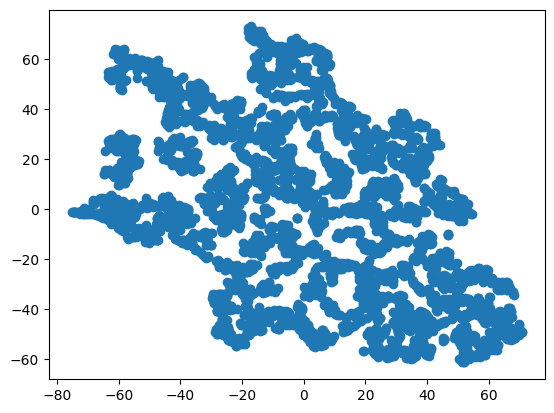

In [51]:
plt.scatter(new_tsne_data[:, 0], new_tsne_data[:, 1]) #c=temp)
plt.show()

Maintenant que l'on s'est séparé de la colonne deg_densité, nous avons une représentation de bcp moins facilemnt clusterisable par un etre humain.  
il a une connexion entre toute les structure visiblement (difficile pour dbscan d'extraire des clusters). Nous allons donc plutot nous orienter vers la gaussian mixtures. Pas kmeans car nos distribution ne sont pas également distribué, donc si on arrive a extraire des groupes ils ne seront probablement pas de la meme taille.

### Clustering - Gaussian mixtures

Nous allons donc essayer de maximiser le silhouette score comme fait avec dbscan.

In [52]:
cov_type = ['full', 'spherical', 'diag', 'tied']
s_scores = {'full': [], 'spherical': [], 'diag': [], 'tied': []}
for type_cov in cov_type:
  for nb_cluster in range(2, 20):
    gm = GaussianMixture(n_components=nb_cluster, random_state=0, covariance_type=type_cov)
    gm.fit(data)
    s_scores[type_cov].append(silhouette_score(new_data, gm.predict(data), metric='euclidean'))

Cherchons dans notre cas quelle est le type de covariance le plus adapté afin d'optimiser le silhouette score.

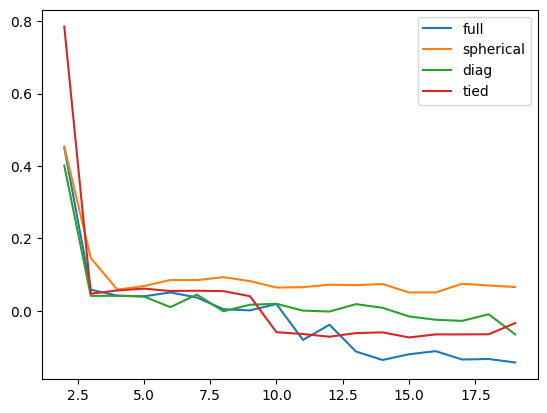

In [53]:
for type_cov in cov_type:
  plt.plot([i for i in range(2, 20)], s_scores[type_cov], label=type_cov)
  plt.legend()

Très clairement d'après le graphique ce dessus, il nous faut utiliser 2 cluster, en utilisant tied en paramètre de covariance

In [59]:
gm = GaussianMixture(n_components=2, random_state=0, covariance_type='tied')
gm.fit(data)
new_dataset['gm'] = gm.predict(data)

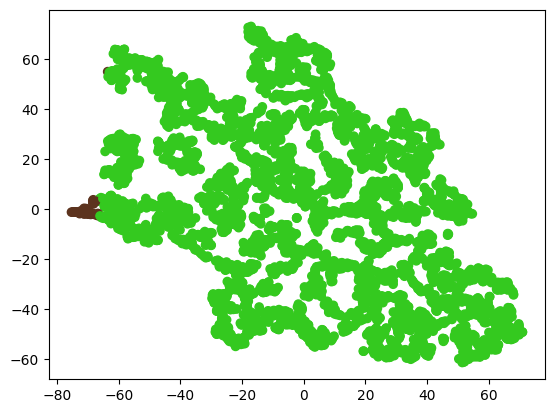

In [60]:
temp = new_dataset['gm'].apply(lambda x: colors[x + 1]).tolist()

plt.scatter(new_tsne_data[:, 0], new_tsne_data[:, 1], c=temp)
plt.show()

#### Analysons le cluster obtenue

In [62]:
pd.set_option('display.max_columns', None)
new_dataset.groupby(by="gm").agg(['mean', 'max', 'min', 'var'])

loypredm2                                     population                 \
         mean        max       min        var           mean     max    min   
gm                                                                            
0   10.691847  29.982547  5.375503   7.495249    7704.406827   87572   1952   
1   12.898847  25.503781  8.847099  10.461792  150965.404255  486828  84961   

                     SNHM18                        
             var       mean   max   min       var  
gm                                                 
0   1.031383e+08  14.461285  44.6  10.4  8.199662  
1   5.532122e+09  14.421277  27.9  12.2  5.493016

In [585]:
dataset.loc[dataset['gm'] == 1].sort_values(by=['population'], ascending=False).head(10)

INSEE         LIBGEO   DEP  REG  loypredm2  code_com  deg_densite  \
1593  31555.0       Toulouse  31.0   76  12.232597   31555.0            1   
2625  44109.0         Nantes  44.0   52  12.301945   44109.0            1   
1841  34172.0    Montpellier  34.0   76  13.743347   34172.0            1   
4754  67482.0     Strasbourg  67.0   44  12.860773   67482.0            1   
1647  33063.0       Bordeaux  33.0   75  13.834281   33063.0            1   
3951  59350.0          Lille  59.0   32  13.857356   59350.0            1   
1994  35238.0         Rennes  35.0   53  11.798332   35238.0            1   
3356  51454.0          Reims  51.0   44  11.297072   51454.0            1   
6133  83137.0         Toulon  83.0   93  12.476965   83137.0            1   
2475  42218.0  Saint-Étienne  42.0   84   8.847099   42218.0            1   

      population  SNHM18  SNHMF18  SNHMFC18  SNHMFE18  SNHMFO18  SNHMHC18  \
1593      486828    15.5     13.9      21.1      10.4       9.5      24.5   
2625      314138    15.7     13.9      21.1      10.7       9.5      25.6   
1841      290053    13.7     12.8      20.4      10.2       9.1      23.6   
4754      284677    14.0     12.9      21.6      10.1       9.7      25.4   
1647      257068    16.1     14.1      22.2      10.7       9.5      28.8   
3951      233098    15.0     13.7      20.5      10.3       9.0      24.1   
1994      217728    14.9     13.5      21.1      10.5       9.3      25.0   
3356      182211    14.0     12.8      22.0      10.4       9.9      28.0   
6133      176198    13.1     12.1      20.3      10.3       9.3      24.3   
2475      173089    13.0     11.9      19.7      10.2       9.4      23.4   

      SNHMHE18  SNHMHO18  latittude  longitude  dbscan  gm  
1593      10.6      11.1  43.596038   1.432095      -1   1  
2625      11.0      10.7  47.232046  -1.548204      -1   1  
1841      10.4      10.7  43.613354   3.869264      -1   1  
4754      10.6      10.8  48.571265   7.767760      -1   1  
1647      11.1      10.7  44.857622  -0.573379       4   1  
3951      10.6      10.3  50.631855   3.046986       4   1  
1994      10.8      10.6  48.111680  -1.681869       4   1  
3356      10.8      11.3  49.251726   4.040156       2   1  
6133      10.6      11.0  43.136537   5.932599       2   1  
2475      10.7      11.2  45.430228   4.378746       2   1

On arrive a discriminer les grande villes des autres.
On pourra remarquer plusieurs chose:
- loyer plus important dans les grande villes en moyennes
- Meme salaire en moyenne
- Plus forte inégalité salariale dans les petites villes